# IPO Analysis Template Notebook (HK / SG / Shanghai)
### Case Study: Shenzhen Edge Medical Co., Ltd. — **EDGE MEDICAL-B (02675.HK)**

**Created:** 2026-02-19  
**Goal:** Provide a reusable, institutional-style IPO analysis template (business + tech moat + financials + valuation + risks + post-IPO monitoring), with Edge Medical as a worked example.

**Primary filings / references (start here):**
- HKEX prospectus (Edge Medical, Dec 30, 2025): https://www1.hkexnews.hk/listedco/listconews/sehk/2025/1230/2025123000029.pdf
- HKEX trading arrangement notice (new listing particulars): https://www.hkex.com.hk/eng/market/sec_tradinfo/tradarng/tradarng_news/premonth/e2675a_260105.htm
- Reuters (Jan 8, 2026) IPO debut context (Edge Medical / Zhipu / Iluvatar): https://www.reuters.com/world/asia-pacific/chinese-tech-companies-led-by-zhipu-ai-climb-hong-kong-debut-2026-01-08/
- Offer price / proceeds (HKEX filing): https://www1.hkexnews.hk/listedco/listconews/sehk/2026/0204/2026020402144.pdf
- Use of proceeds snapshot (public PDF summary): https://www.ccnew.com.hk/home/upload/ipo/20251230091723_1734205700.pdf

> Note: This notebook is designed to be **data-source agnostic**. You can plug in numbers from prospectus, earnings releases, Bloomberg/FactSet, or your own database pipeline.


## 0) Environment setup

If you are running locally, create a dedicated environment for reproducibility.


In [1]:
# Core
import math
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


## 1) Company snapshot (editable)

Fill in the structured metadata once. This makes it easy to standardize comparisons across IPOs.


In [2]:
company = {
    "name": "Shenzhen Edge Medical Co., Ltd.",
    "short_name": "EDGE MEDICAL-B",
    "ticker": "02675.HK",
    "exchange": "HKEX",
    "sector": "Medical Devices / Surgical Robotics",
    "founded_year": 2017,
    "listing_date": "2026-01-08",
    "board_lot": 100,
    "offer_price_hkd": 43.24,   # Offer price per H Share (HKD)
    "currency_reporting": "RMB",
    "links": {
        "prospectus_hkex_pdf": "https://www1.hkexnews.hk/listedco/listconews/sehk/2025/1230/2025123000029.pdf",
        "trading_arrangement_notice": "https://www.hkex.com.hk/eng/market/sec_tradinfo/tradarng/tradarng_news/premonth/e2675a_260105.htm",
        "over_allotment_notice": "https://www1.hkexnews.hk/listedco/listconews/sehk/2026/0204/2026020402144.pdf",
    }
}
company


{'name': 'Shenzhen Edge Medical Co., Ltd.',
 'short_name': 'EDGE MEDICAL-B',
 'ticker': '02675.HK',
 'exchange': 'HKEX',
 'sector': 'Medical Devices / Surgical Robotics',
 'founded_year': 2017,
 'listing_date': '2026-01-08',
 'board_lot': 100,
 'offer_price_hkd': 43.24,
 'currency_reporting': 'RMB',
 'links': {'prospectus_hkex_pdf': 'https://www1.hkexnews.hk/listedco/listconews/sehk/2025/1230/2025123000029.pdf',
  'trading_arrangement_notice': 'https://www.hkex.com.hk/eng/market/sec_tradinfo/tradarng/tradarng_news/premonth/e2675a_260105.htm',
  'over_allotment_notice': 'https://www1.hkexnews.hk/listedco/listconews/sehk/2026/0204/2026020402144.pdf'}}

## 2) Financial track record (prospectus numbers)

### Edge Medical (from prospectus summaries / deal notes)
- Revenue (RMB): 2023 **480.4m**, 2024 **1,599.9m**, 1H2025 **1,493.8m**
- Net loss (RMB): 2023 **2,128.7m**, 2024 **2,185.1m**, 1H2025 **890.9m**

> You should verify & refine with the full prospectus tables (income statement, cash flow, segment breakdown).


In [3]:
# --- Input table (edit as you extract more detail from the prospectus) ---
financials = pd.DataFrame(
    [
        {"period": "FY2023", "revenue": 480.4e6, "gross_profit": np.nan, "net_income": -2128.7e6, "op_cashflow": np.nan, "capex": np.nan},
        {"period": "FY2024", "revenue": 1599.9e6, "gross_profit": np.nan, "net_income": -2185.1e6, "op_cashflow": np.nan, "capex": np.nan},
        {"period": "1H2025", "revenue": 1493.8e6, "gross_profit": np.nan, "net_income": -890.9e6, "op_cashflow": np.nan, "capex": np.nan},
    ]
)

financials


,period,revenue,gross_profit,net_income,op_cashflow,capex
0,FY2023,4.804000e+08,NaN,-2.128700e+09,NaN,NaN
1,FY2024,1.599900e+09,NaN,-2.185100e+09,NaN,NaN
2,1H2025,1.493800e+09,NaN,-8.909000e+08,NaN,NaN


### 2.1 KPI helpers

These functions standardize common IPO metrics:
- Growth (YoY), annualized run-rate (for interim periods)
- Gross margin (if gross profit available)
- Net margin


In [5]:
def yoy_growth(curr, prev):
    if prev is None or pd.isna(prev) or prev == 0 or pd.isna(curr):
        return np.nan
    return (curr / prev) - 1.0

def safe_div(a, b):
    if b is None or pd.isna(b) or b == 0 or pd.isna(a):
        return np.nan
    return a / b

def annualize_interim(value, months=6):
    # Simple annualization: value * (12 / months)
    if value is None or pd.isna(value):
        return np.nan
    return value * (12 / months)

kpi = financials.copy()
kpi["revenue_yoy"] = [np.nan, yoy_growth(kpi.loc[1,"revenue"], kpi.loc[0,"revenue"]), np.nan]
kpi["gross_margin"] = kpi.apply(lambda r: safe_div(r["gross_profit"], r["revenue"]), axis=1)
kpi["net_margin"] = kpi.apply(lambda r: safe_div(r["net_income"], r["revenue"]), axis=1)
kpi


,period,revenue,gross_profit,net_income,op_cashflow,capex,revenue_yoy,gross_margin,net_margin
0,FY2023,4.804000e+08,NaN,-2.128700e+09,NaN,NaN,NaN,NaN,-4.431099
1,FY2024,1.599900e+09,NaN,-2.185100e+09,NaN,NaN,2.33035,NaN,-1.365773
2,1H2025,1.493800e+09,NaN,-8.909000e+08,NaN,NaN,NaN,NaN,-0.596398


### 2.2 Quick charts

Default matplotlib colors (no styling overrides).


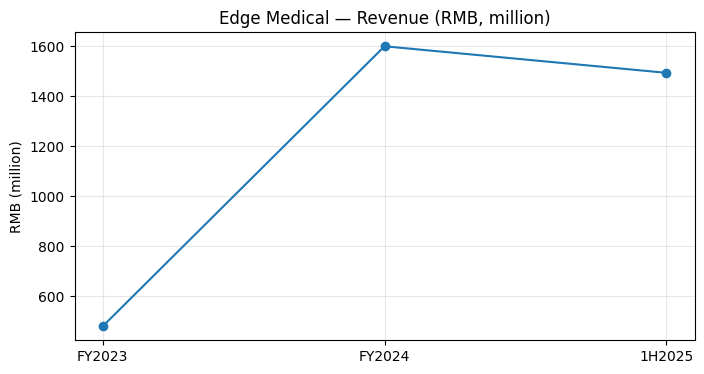

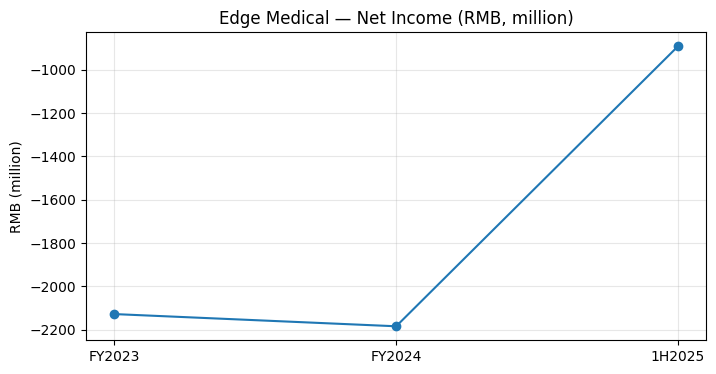

In [6]:
# Revenue trend
plt.figure(figsize=(8,4))
plt.plot(financials["period"], financials["revenue"]/1e6, marker="o")
plt.title("Edge Medical — Revenue (RMB, million)")
plt.ylabel("RMB (million)")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

# Net income trend
plt.figure(figsize=(8,4))
plt.plot(financials["period"], financials["net_income"]/1e6, marker="o")
plt.title("Edge Medical — Net Income (RMB, million)")
plt.ylabel("RMB (million)")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()


## 3) Deal terms & proceeds

For HK IPOs, make sure you capture:
- Offer price, offer size, greenshoe (over-allotment)
- Gross proceeds vs net proceeds (fees)
- Cornerstone investors (if any)
- Lock-up structure


In [7]:
deal = {
    "offer_price_hkd": 43.24,
    # From deal notes / summaries (verify against final allotment announcement & prospectus)
    "gross_proceeds_hkd": 1198.7e6,
    "net_proceeds_hkd": 1116.6e6,
    "listing_expenses_hkd": 82.1e6,
    # Use-of-proceeds (from public summary; replace with prospectus table when extracted)
    "use_of_proceeds_pct": {
        "R&D multi-port laparoscopic robot (MP series)": 0.23,
        "R&D single-port laparoscopic robot (SP series)": 0.19,
        "Commercialization of core products": 0.20,
        "Expand production capacity": 0.10,
        "Other products / pipeline": 0.08,
        "Working capital / general": 0.20  # placeholder remainder; verify exact split in prospectus
    }
}
deal


{'offer_price_hkd': 43.24,
 'gross_proceeds_hkd': 1198700000.0,
 'net_proceeds_hkd': 1116600000.0,
 'listing_expenses_hkd': 82100000.0,
 'use_of_proceeds_pct': {'R&D multi-port laparoscopic robot (MP series)': 0.23,
  'R&D single-port laparoscopic robot (SP series)': 0.19,
  'Commercialization of core products': 0.2,
  'Expand production capacity': 0.1,
  'Other products / pipeline': 0.08,
  'Working capital / general': 0.2}}

### 3.1 Use-of-proceeds allocation (visual)

A quick check: does spending match the investment thesis?


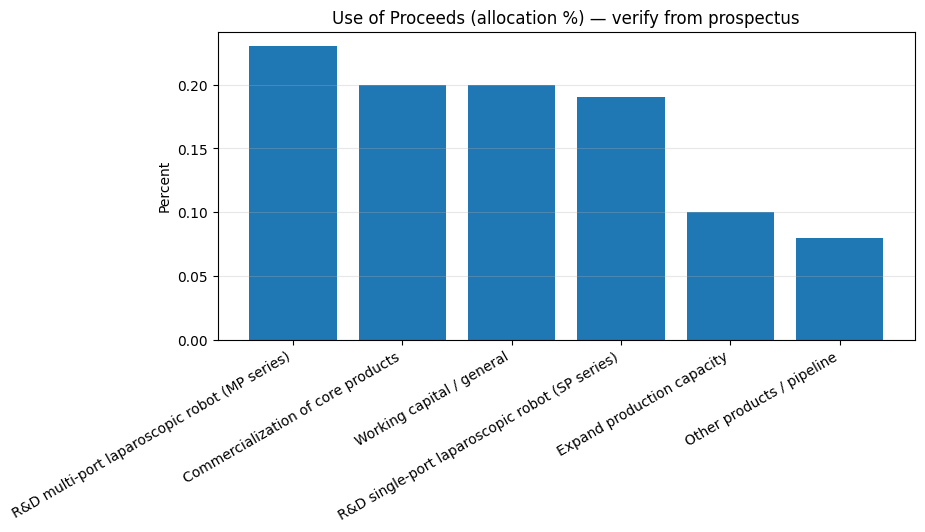

,pct
R&D multi-port laparoscopic robot (MP series),0.23
Commercialization of core products,0.20
Working capital / general,0.20
R&D single-port laparoscopic robot (SP series),0.19
Expand production capacity,0.10
Other products / pipeline,0.08


In [8]:
uop = pd.Series(deal["use_of_proceeds_pct"]).sort_values(ascending=False)
plt.figure(figsize=(9,4))
plt.bar(uop.index, uop.values)
plt.title("Use of Proceeds (allocation %) — verify from prospectus")
plt.ylabel("Percent")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

uop.to_frame("pct")


## 4) Product, technology moat & evidence pack

For “hard-tech” IPOs (robotics, AI chips, LiDAR, medtech devices), build a **moat evidence pack**.

### Checklist (fill with evidence)
- ✅ Regulatory approvals (NMPA, FDA, CE, etc.)  
- ✅ Clinical adoption / installed base / training centers  
- ✅ Patents / defensible IP  
- ✅ Manufacturing readiness (yield, QA, suppliers)  
- ✅ Unit economics (gross margin by product line)  
- ✅ Competitive landscape (domestic + global)

> In the case of Edge Medical, the IPO materials highlight multi-port & single-port surgical robots and expansion of commercialization and R&D (verify in prospectus).


In [9]:
moat = pd.DataFrame(
    [
        {"dimension":"Regulatory approvals", "what_to_collect":"Approval letters, scope, indication, geography", "edge_medical_notes":"(Add from prospectus/press)"},
        {"dimension":"Installed base & utilization", "what_to_collect":"# systems installed, utilization rate, # hospitals, training centers", "edge_medical_notes":"(Add)"},
        {"dimension":"IP / patents", "what_to_collect":"Patent count by jurisdiction + key claims + expiry", "edge_medical_notes":"(Add)"},
        {"dimension":"Clinical outcomes", "what_to_collect":"Trial results, safety, endpoints, comparisons", "edge_medical_notes":"(Add)"},
        {"dimension":"Manufacturing & supply chain", "what_to_collect":"Key suppliers, single-source risks, capacity expansion plan", "edge_medical_notes":"(Add)"},
        {"dimension":"Competitive landscape", "what_to_collect":"Peers, price/performance, go-to-market differences", "edge_medical_notes":"(Add)"},
    ]
)
moat


,dimension,what_to_collect,edge_medical_notes
0,Regulatory approvals,"Approval letters, scope, indication, geography",(Add from prospectus/press)
1,Installed base & utilization,"# systems installed, utilization rate, # hospi...",(Add)
2,IP / patents,Patent count by jurisdiction + key claims + ex...,(Add)
3,Clinical outcomes,"Trial results, safety, endpoints, comparisons",(Add)
4,Manufacturing & supply chain,"Key suppliers, single-source risks, capacity e...",(Add)
5,Competitive landscape,"Peers, price/performance, go-to-market differe...",(Add)


## 5) Peer set & valuation framework

### 5.1 Choose peers (3 buckets)
- **Global leaders** (e.g., Intuitive Surgical for robotic surgery)
- **China / Asia medtech & robotics comps**
- **Adjacent comps** (hospital equipment, endoscopy, minimally invasive tools)

### 5.2 Valuation methods
- EV/Sales (common when loss-making)
- Gross profit multiple (if gross profit is stable & comparable)
- DCF only if you can defend long-term assumptions


In [10]:
# Fill peers with your chosen comparables (tickers + key multiples).
peers = pd.DataFrame(
    [
        {"name":"Intuitive Surgical", "ticker":"ISRG", "market":"US", "ev_sales_fwd": np.nan, "notes":"Global benchmark for surgical robotics"},
        {"name":"(Add China peer 1)", "ticker":"", "market":"CN/HK", "ev_sales_fwd": np.nan, "notes":""},
        {"name":"(Add China peer 2)", "ticker":"", "market":"CN/HK", "ev_sales_fwd": np.nan, "notes":""},
    ]
)
peers


,name,ticker,market,ev_sales_fwd,notes
0,Intuitive Surgical,ISRG,US,NaN,Global benchmark for surgical robotics
1,(Add China peer 1),,CN/HK,NaN,
2,(Add China peer 2),,CN/HK,NaN,


### 5.3 Edge Medical — scenario valuation (template)

You need:
- Shares outstanding (post-IPO) or market cap at offer
- Net debt / cash (from balance sheet)
- Forward sales estimate (run-rate)

This cell is built so you can plug in real values after extracting from prospectus/financials.


In [11]:
# --- Inputs (replace with exact prospectus figures) ---
shares_outstanding = np.nan  # e.g., total shares post-IPO
net_cash_rmb = np.nan        # cash - debt (RMB), from balance sheet
fx_hkd_rmb = np.nan          # FX rate if needed for cross-currency consistency

# Forward sales proxy: annualize 1H2025 revenue (simple, not seasonality-adjusted)
rev_fwd_rmb = annualize_interim(financials.loc[financials["period"]=="1H2025","revenue"].iloc[0], months=6)

# Valuation multiple scenarios (EV/Sales)
ev_sales_scenarios = [5, 8, 12, 15]

scenario_rows = []
for m in ev_sales_scenarios:
    ev_rmb = m * rev_fwd_rmb
    equity_value_rmb = ev_rmb + (net_cash_rmb if not pd.isna(net_cash_rmb) else 0.0)
    scenario_rows.append({"EV/Sales": m, "Forward Sales (RMB)": rev_fwd_rmb, "EV (RMB)": ev_rmb, "Equity Value (RMB)": equity_value_rmb})

valuation_scenarios = pd.DataFrame(scenario_rows)
valuation_scenarios


,EV/Sales,Forward Sales (RMB),EV (RMB),Equity Value (RMB)
0,5,2.987600e+09,1.493800e+10,1.493800e+10
1,8,2.987600e+09,2.390080e+10,2.390080e+10
2,12,2.987600e+09,3.585120e+10,3.585120e+10
3,15,2.987600e+09,4.481400e+10,4.481400e+10


## 6) Governance, incentives & red flags

For IPOs, many blow-ups come from governance, not technology.
Score each item with evidence from prospectus.


In [12]:
risk_checklist = pd.DataFrame(
    [
        {"category":"Governance", "item":"Founder control / WVR / related-party transactions", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Customers", "item":"Top-5 revenue concentration", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Product", "item":"Single-product dependency / pipeline maturity", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Regulatory", "item":"Approval risk / post-market surveillance", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Manufacturing", "item":"Single-source components / yield risks", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Financial", "item":"Cash runway (<24 months) / refinancing risk", "score_0to5": np.nan, "evidence_link": ""},
        {"category":"Market", "item":"Pricing pressure / reimbursement / adoption barriers", "score_0to5": np.nan, "evidence_link": ""},
    ]
)
risk_checklist


,category,item,score_0to5,evidence_link
0,Governance,Founder control / WVR / related-party transact...,NaN,
1,Customers,Top-5 revenue concentration,NaN,
2,Product,Single-product dependency / pipeline maturity,NaN,
3,Regulatory,Approval risk / post-market surveillance,NaN,
4,Manufacturing,Single-source components / yield risks,NaN,
5,Financial,Cash runway (<24 months) / refinancing risk,NaN,
6,Market,Pricing pressure / reimbursement / adoption ba...,NaN,


## 7) Post-IPO monitoring plan (90 days / 1 year)

### 7.1 What to track weekly (first 90 days)
- Price vs offer, volume, free float
- Insider / cornerstone lock-up dates
- Any supplemental HKEX filings (over-allotment, share awards, etc.)
- Major contract wins, regulatory milestones, hospital deployments

### 7.2 What to track quarterly (1 year)
- Revenue mix (domestic vs overseas)
- Gross margin trend (hardware vs consumables/services)
- R&D cadence vs roadmap
- Unit installs, utilization, training center expansion


In [13]:
monitoring = pd.DataFrame(
    [
        {"horizon":"Weekly (0-90d)", "metric":"Price vs offer", "how":"% change vs HK$ offer", "notes":""},
        {"horizon":"Weekly (0-90d)", "metric":"Volume / liquidity", "how":"Avg daily turnover, spread", "notes":""},
        {"horizon":"Event-driven", "metric":"HKEX filings", "how":"Check announcements & circulars", "notes":company["links"]["prospectus_hkex_pdf"]},
        {"horizon":"Quarterly", "metric":"Revenue & GM", "how":"Earnings vs prospectus track record", "notes":""},
        {"horizon":"Quarterly", "metric":"Cash runway", "how":"Cash burn vs net proceeds plan", "notes":""},
        {"horizon":"Quarterly", "metric":"Operational KPIs", "how":"# installs, utilization, hospital count", "notes":""},
    ]
)
monitoring


,horizon,metric,how,notes
0,Weekly (0-90d),Price vs offer,% change vs HK$ offer,
1,Weekly (0-90d),Volume / liquidity,"Avg daily turnover, spread",
2,Event-driven,HKEX filings,Check announcements & circulars,https://www1.hkexnews.hk/listedco/listconews/s...
3,Quarterly,Revenue & GM,Earnings vs prospectus track record,
4,Quarterly,Cash runway,Cash burn vs net proceeds plan,
5,Quarterly,Operational KPIs,"# installs, utilization, hospital count",


## 8) Output: One-page IC memo (template)

Fill this and export to PDF for your investment committee / personal decision log.


In [14]:
ic_memo = {
    "Thesis (1-2 lines)": "",
    "What must be true? (3 bullets)": ["", "", ""],
    "Key risks (3 bullets)": ["", "", ""],
    "Valuation view": "",
    "Catalysts (0-12m)": ["", "", ""],
    "Decision": "Watch / Buy / Avoid / Needs more data",
    "Next actions": ["Extract full prospectus financial tables", "Build peer comp table with live multiples", "Define lock-up calendar"]
}
ic_memo


{'Thesis (1-2 lines)': '',
 'What must be true? (3 bullets)': ['', '', ''],
 'Key risks (3 bullets)': ['', '', ''],
 'Valuation view': '',
 'Catalysts (0-12m)': ['', '', ''],
 'Decision': 'Watch / Buy / Avoid / Needs more data',
 'Next actions': ['Extract full prospectus financial tables',
  'Build peer comp table with live multiples',
  'Define lock-up calendar']}